<a href="https://colab.research.google.com/github/AndrewMinyoungKim/Stock-Forecaster/blob/main/Stock_Forecasting_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScalerstock prices
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

## Load Data From CSV

All historical data is retrieved from: https://www.nasdaq.com/market-activity/quotes/historical

#### Configured Variables

In [ ]:
# file path to csv data
csv_file_path = "/content/HistoricalData_1695673453163.csv"

# set number of prior points to use depending on how much data you have
x_len = 40

#### Retrieve Data

In [ ]:
raw_data = pd.read_csv(csv_file_path)
raw_data.head()

,Date,Close/Last,Volume,Open,High,Low
0,09/22/2023,$174.79,56725390,$174.67,$177.079,$174.05
1,09/21/2023,$173.93,63149120,$174.55,$176.30,$173.86
2,09/20/2023,$175.49,58436180,$179.26,$179.695,$175.40
3,09/19/2023,$179.07,51826940,$177.52,$179.63,$177.13
4,09/18/2023,$177.97,67257570,$176.48,$179.38,$176.17


In [ ]:
dataset = raw_data[["Date", "Open"]]
dataset.head(3)

,Date,Open
0,09/22/2023,$174.67
1,09/21/2023,$174.55
2,09/20/2023,$179.26


In [ ]:
remove_dollar_sign = lambda x: float(x.replace('$', ''))
# https://saturncloud.io/blog/converting-currency-with-to-numbers-in-python-pandas/#:~:text=One%20way%20to%20convert%20currency,remaining%20string%20to%20a%20float.

In [ ]:
dataset['Open'] = dataset['Open'].apply(remove_dollar_sign)
dataset

<ipython-input-89-2743ef9a83a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Open'] = dataset['Open'].apply(remove_dollar_sign)


,Date,Open
0,09/22/2023,174.6700
1,09/21/2023,174.5500
2,09/20/2023,179.2600
3,09/19/2023,177.5200
4,09/18/2023,176.4800
...,...,...
1252,10/01/2018,56.9875
1253,09/28/2018,56.1975
1254,09/27/2018,55.9550
1255,09/26/2018,55.2500


## Preprocess Data

#### Only use "Open" value

In [ ]:
dataset = dataset.iloc[:, 1:2].values
print(dataset.shape)

(1257, 1)


#### Train/Test Split

In [ ]:
# split training/test sets before normalization so the test data does not affect normalization of train data and vice versa
split = int(len(dataset) * 0.8)
train_set, test_set = dataset[:split], dataset[split:]

#### Normalize Data

In [ ]:
normalize = MinMaxScaler(feature_range=(0,1))
scaled_train_set = normalize.fit_transform(train_set)
scaled_test_set = normalize.fit_transform(test_set)

#### Create Supervised Learning Data i.e. Feature Vector/Label Split

In [ ]:
# use x_len prior stock prices to predict the next stock price
def set_supervised_learning(dataset):
  x, y = [], []
  for i in range(x_len, len(dataset)):
    x.append(scaled_train_set[i-x_len:i, 0])
    y.append(scaled_train_set[i, 0])
  return x, y

In [ ]:
x_train, y_train = set_supervised_learning(train_set)
x_test, y_test = set_supervised_learning(test_set)

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(965, 40) (965,) (212, 40) (212,)


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(965, 40, 1)

### Neural Network Model

In [ ]:
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 40, 50)            7950      
                                                                 
 dropout_8 (Dropout)         (None, 40, 50)            0         
                                                                 
 gru_9 (GRU)                 (None, 40, 50)            15300     
                                                                 
 dropout_9 (Dropout)         (None, 40, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 40, 50)            15300     
                                                                 
 dropout_10 (Dropout)        (None, 40, 50)            0         
                                                                 
 gru_11 (GRU)                (None, 50)               

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
31/31 [==============================] - 12s 94ms/step - loss: 0.0553 - accuracy: 0.0010
Epoch 2/30
31/31 [==============================] - 3s 99ms/step - loss: 0.0083 - accuracy: 0.0010
Epoch 3/30
31/31 [==============================] - 4s 119ms/step - loss: 0.0063 - accuracy: 0.0010
Epoch 4/30
31/31 [==============================] - 3s 92ms/step - loss: 0.0062 - accuracy: 0.0010
Epoch 5/30
31/31 [==============================] - 3s 92ms/step - loss: 0.0052 - accuracy: 0.0010
Epoch 6/30
31/31 [==============================] - 3s 90ms/step - loss: 0.0056 - accuracy: 0.0010
Epoch 7/30
31/31 [==============================] - 4s 132ms/step - loss: 0.0045 - accuracy: 0.0010
Epoch 8/30
31/31 [==============================] - 3s 91ms/step - loss: 0.0046 - accuracy: 0.0010
Epoch 9/30
31/31 [==============================] - 3s 90ms/step - loss: 0.0042 - accuracy: 0.0010
Epoch 10/30
31/31 [==============================] - 3s 91ms/step - loss: 0.0038 - accuracy: 0.0010
Epoch 

#### Testing The Model

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model_test_results = model.predict(x_test)

7/7 [==============================] - 2s 21ms/step


In [ ]:
y_stock_price = np.reshape(y_test, (y_test.shape[0], 1))
y_stock_price.shape == model_test_results.shape

True

In [ ]:
estimated_stock = normalize.inverse_transform(model_test_results)
real_stock = normalize.inverse_transform(y_stock_price)

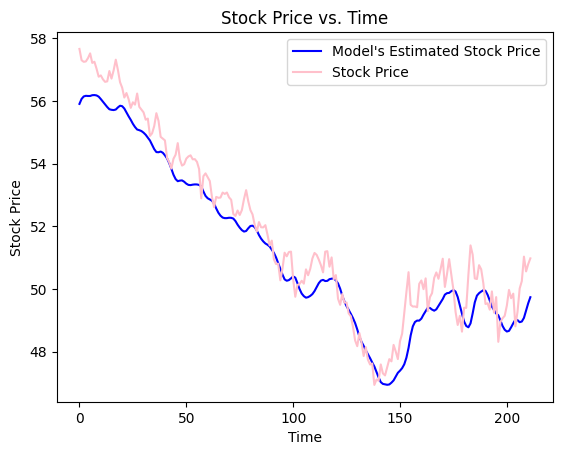

In [ ]:
plt.plot(estimated_stock, color='blue', label="Model's Estimated Stock Price")
plt.plot(real_stock, color='pink', label='Stock Price')
plt.title('Stock Price vs. Time')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
# real_stock_arr, estimated_stock_arr = real_stock.squeeze(), estimated_stock.squeeze()
largest_deviation = 0
smallest_dev = float('inf')

for i in range(len(estimated_stock)):
  difference = abs(estimated_stock[i] - real_stock[i])
  if(difference > largest_deviation):
    largest_deviation = difference
  if(difference < smallest_dev):
    smallest_dev = difference

print(f"Largest Deviation from actual value: {largest_deviation}")
print(f"Smallest Deviation from actual value: {smallest_dev}")

Largest Deviation from actual value: [2.48953307]
Smallest Deviation from actual value: [0.00539843]


In [ ]:
test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=2)

print(f"Test Loss: {np.around(test_loss * 100, 2)}%")
print(f"Test Accuracy: {np.around(test_acc * 100, 6)}%")

7/7 - 2s - loss: 0.0014 - accuracy: 0.0000e+00 - 2s/epoch - 351ms/step
Test Loss: 0.14%
Test Accuracy: 0.0%
